# KANN: Koopman Analysis of Neural Networks

This code visualize how we capture dominant features of normal beats using the dominant eigenvectors ${u_j}$ of the Koopman operator over trained LSTM autoencoder model on classification using the Electrocardiogram (ECG) dataset.

### Imports

In [1]:
!pip install kann

Defaulting to user installation because normal site-packages is not writeable
  Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)


In [2]:
import torch
from torch import nn
import numpy as np
import argparse
import copy
import math
from tqdm import tqdm

import kann

### Hyperparameters

define hyperparamas and load data (ECG dataset)

In [3]:
# hyperparameters
parser = argparse.ArgumentParser(description="ECG Classification")
parser.add_argument("-f")
parser.add_argument("--epochs", type=int, default=150)
parser.add_argument("--batch_size", type=int, default=20)
parser.add_argument("--optimizer", type=str, default="Adam")
parser.add_argument("--lr", type=float, default=1e-3)
parser.add_argument("--clip", type=float, default=1)
parser.add_argument("--arch", type=str, default="LSTM")
parser.add_argument("--num_layers", type=int, default=1)
parser.add_argument("--hidden_size", type=int, default=64)
parser.add_argument("--weight_decay", type=float, default=5e-3)
parser.add_argument("--patience", type=int, default=2)
parser.add_argument("--seed", type=int, default=1234)


args = parser.parse_args()

seed = 1234
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)
np.random.seed(seed)

# Use cuda if available
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
args.device = device

### Load data and weights

Load the ECG data. The data can be downloaded from here: http://timeseriesclassification.com/description.php?Dataset=ECG5000 and it should be located in the "../data/ecg_task" path. If weights are loaded, they should be located in "../data/ecg_task/weights".


In [4]:
ecg_data_path = '../data/ecg_task/ECG5000/'
seq_len, n_features, train_dataset, val_dataset, test_normal_dataset, test_anomaly_dataset = kann.ecg_data(ecg_data_path,
                                                                                                      args)

In [5]:
model = kann.RecurrentAutoencoder(seq_len, n_features, args.arch, args.hidden_size)
model = model.to(device)

pref = '../data/ecg_task/weights'
suff = 'ep={}_hidden={}_clip={}_lr={}_wd={}_patience={}'. \
    format(args.epochs, args.hidden_size, args.clip, args.lr, args.weight_decay, args.patience)
num_sequences = len(train_dataset)
num_val_seq = len(val_dataset)

In [6]:
def train():
    best_loss = math.inf
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=args.patience)
    criterion = nn.L1Loss(reduction='sum').to(device)
    best_model_wts = copy.deepcopy(model.state_dict())
    stats = tqdm(range(1, args.epochs + 1), total=args.epochs, leave=False)

    for _ in stats:
        model.train()
        train_losses = []
        for seq_true in train_dataset:
            optimizer.zero_grad()
            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)
            loss = criterion(seq_pred, seq_true)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        val_losses = []
        model.eval()
        with torch.no_grad():
            for seq_true in val_dataset:
                seq_true = seq_true.to(device)
                seq_pred = model(seq_true)
                loss = criterion(seq_pred, seq_true)
                val_losses.append(loss.item())
        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)
        scheduler.step(val_loss)
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
        stats.set_description(f't_loss {train_loss:.5f} v_loss {val_loss:.5f}')
    model.load_state_dict(best_model_wts)
    print("Best validation loss: {.:5f}".format(best_loss))

Load pretrained model or train LSTM model

In [7]:
# To train the model from scratch, uncomment the next 3 lines.
# train()
# with open('{}/LSTM_example_ecg_classification_model_{}.pt'.format(pref, suff), 'wb') as f:
#     torch.save(model.state_dict(), f)

# Else if you choose to train the model, comment out the next 2 lines.
with open('{}/LSTM_ecg_classification_model_{}.pt'.format(pref, suff), 'rb') as f:
    model.load_state_dict(torch.load(f, map_location=torch.device(device)))

### ECG - dominant features of normal beats 

Here we compute C from $H$ - [batch_size x seq_len x hidden_dim] tensor of hidden state sequences. 
Then we identify dominant eigenvectors for normal/anomalous states via $Eq. 7$. To determine which eigenvectors are dominant, we employ $Eq. 10$. In the end, we project onto dominant pair and reconstruct via $Eq. 11$

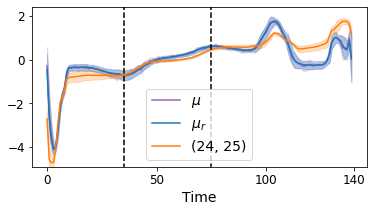

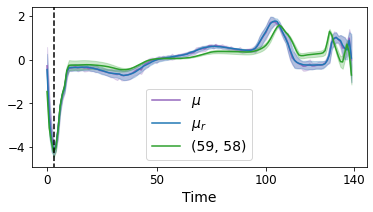

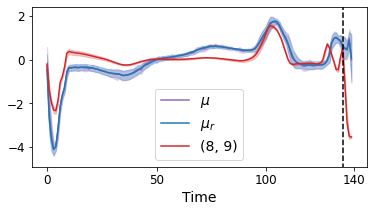

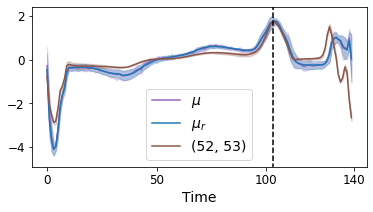

In [8]:
# evaluation starts
n_time = test_normal_dataset[0].shape[0]
signo = np.stack(test_normal_dataset[:args.batch_size]).squeeze()           # batch of normal signals

# generate normal/anomalous hidden states in Zno/Zan
model.eval()
with torch.no_grad():
    hs_no, hs_an = [], []
    for seq_true in test_normal_dataset[:args.batch_size]:
        seq_true = seq_true.to(device)
        states = model.encoder.unroll_states(seq_true)
        hs_no.append(states.squeeze().detach().cpu().numpy())
    Zno = np.stack(hs_no)

# compute Koopman operator
kann_ = kann.KANN(Zno, emb="TruncatedSVD")
C = kann_.compute_KOP()
D, V = np.linalg.eig(C)
U = np.linalg.inv(V)

# identify dominant eigs for normal/anomalous states
Zpno, Zpnov, Zpnovn = kann_.Zp, kann_.Zp @ V, np.abs(kann_.Zp @ V)


# the contribution of every eigenvector across time for every sample in batch (batch x eig)
eigno_dom = np.sum(Zpnovn, axis=1)
eigno_dom_avg = np.mean(eigno_dom, axis=0)
JJno = np.argsort(eigno_dom_avg)[::-1]

# project onto dominant pair and reconstruct (only for normal signals)
pairs = 4
model.eval()
with torch.no_grad():

    Zpno_last = kann_.emb_engine.inverse_transform(Zpno[:, -1])
    signo_dec = []
    for idx in range(args.batch_size):
        signo_dec.append(model.decoder(torch.from_numpy(Zpno_last[idx]).to(device)))
    signo_dec = np.stack(signo_dec).squeeze()

    SIGNO_R_DEC = []
    for p in range(pairs):
        Zpno_r = Zpno @ np.abs(V[:, JJno[2 * p:2 * (p + 1)]] @ U[JJno[2 * p:2 * (p + 1)], :])
        Zno_r_last = kann_.recover_states(Zpno_r, r=Zpno_r.shape[-1])[:, -1]

        signo_r_dec = []
        for idx in range(args.batch_size):
            signo_r_dec.append(model.decoder(torch.from_numpy(Zno_r_last[idx][None, ...]).to(device)))
        SIGNO_R_DEC.append(np.stack(signo_r_dec).squeeze())
    SIGNO_R_DEC = np.stack(SIGNO_R_DEC)

# visualize the results
colors = ['tab:purple', 'tab:blue', '']
colors_aux = ['tab:orange', 'tab:green', 'tab:red', 'tab:brown']
names = ['{}-{}'.format(JJno[2*p], JJno[2*p + 1]) for p in range(pairs)]
verts = [[35, 75], [3], [135], [103]]
legend = ['({}, {})'.format(JJno[2 * p], JJno[2 * p + 1]) for p in range(pairs)]
for p in range(pairs):
    colors[-1] = colors_aux[p]
    kann.vis_median_mad((signo, signo_dec, SIGNO_R_DEC[p]), n_time,
                   ['$\mu$', '$\mu_r$', legend[p]], colors, names[p], verts[p])